## Configuration for Colab

In [1]:
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

## Import modules

# 07. Behavior Cloning (without HER)

[A. Nair et al., "Overcoming Exploration in Reinforcement Learning with Demonstrations." arXiv preprint arXiv:1709.10089, 2017.](https://arxiv.org/pdf/1709.10089.pdf)

Exploration in environments with sparse rewards has been a persistent problem in reinforcement learning. Many tasks are natural to  specify with a sparse reward, and manually shaping a reward function can result in suboptimal performance. However, finding a non-zero reward is exponentially more difficult with increasing task horizon or action dimensionality. In  this  paper, the authors use demonstrations to overcome the exploration problem and successfully learn to perform long-horizon, multi-step tasks with continuous control such as stacking blocks with a robot arm.

### DDPG
For learning in high-dimentional and continous action spaces, the authors of DDPG combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). Please see *03.DDPG.ipynb* for detailed description of DDPG.

### Demonstration Buffer
It maintains a second replay buffer $R_D$ where we store our the demonstration data in the same format as the original replay buffer $R$. In each minibatch, we draw extra $N_D$ examples from $R_D$ to use as off-policy replay data for the update step. These examples are included in both the actor and critic update.

### Behavior Cloning Loss
It computes only on the demonstration examples for training the actor.
$$
L_{BC} = \underset{i=1}{\overset{N_D}\sum} \lVert \pi (s_i | \theta_\pi) - a_i \rVert^2
$$
This loss is a standard loss in imitation learning, but this paper shows that using it as an auxiliary loss for RL improves learning significantly. The gradient applied to the actor parameters $\theta_\pi$ is:
$$
L_A = - \lambda_1 \nabla_{\theta_{\pi}}J + \lambda_2 \nabla_{\theta_{\pi}} L_{BC}
$$
Two parameters called  $\lambda_1$ ,  $\lambda_2$  are used to weight the contributions.

### Q-Filter
Using the above loss prevents the learned policy from improving significantly beyond the demonstration policy, as the actor is always tied back to the demonstrations. To avoid this problem, the authors apply the behavior cloning loss only to states where the critic $Q(s,a)$ determines that action of the demonstration is better than actor's action:
$$
L_{BC} = \underset{i=1}{\overset{N_D}\sum}\lVert \pi (s_i | \theta_\pi) - a_i \rVert^2 \mathbb{1}_{Q(s_i, a_i) > Q(s_i, \pi(s_i))}
$$


In [2]:
import random
import numpy as np
import torch

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Set random seed

In [3]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# By using the same seed, all these libraries will produce the same sequence of random numbers each time the code is run, ensuring consistent results across runs.
seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## OU Noise
*Ornstein-Uhlenbeck* process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference:
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).
*segmentEnv* is an reset wrapper class to reset state to customized state.


## Muti Agent
Here is a summary of Muti agent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_plot              | plot the training progresses.                        |
|\_target_soft_update| soft update from the local model to the target model.|

## Initialize
We make the demonstration using the well-trained agent in advance. (The given demo.pkl is created using *03.DDPG* agent.)

In [9]:
import pickle

# load demo on replay memory
demo_path = "demo.pkl"
with open(demo_path, "rb") as f:
    demo = pickle.load(f)

In [10]:
from learner import MutiAgent
# parameters
n_agent = 3
num_frames = 30000
memory_size = 100000
batch_size = 128
demo_batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

env_id = "Pendulum-v1"

agent = MutiAgent(
    env_id,
    memory_size,
    n_agent,
    batch_size,
    demo_batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    demo,
    initial_random_steps=initial_random_steps,
)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


0.096087605
0.060104348
0.096087605
[device(type='cuda'), device(type='cuda'), device(type='cuda')]


## Train

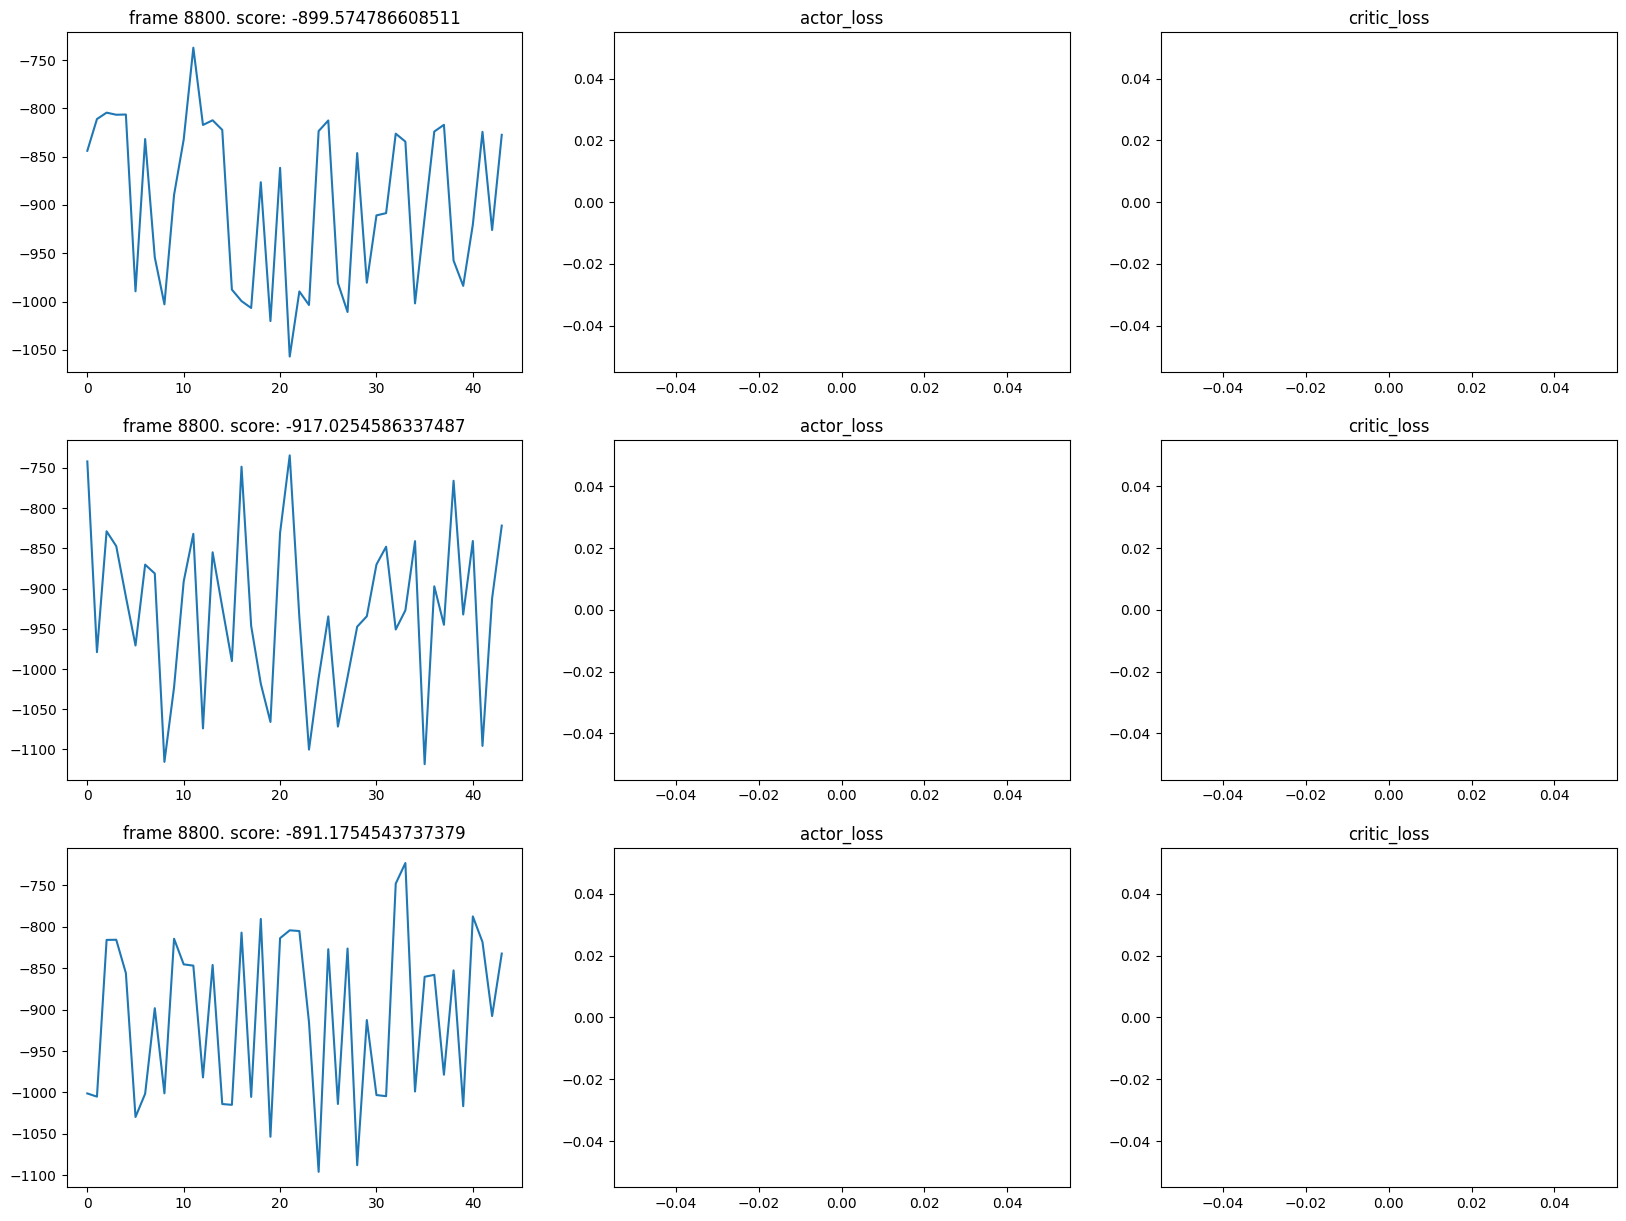

In [ ]:
agent.train(num_frames)

In [ ]:
agent.test()